# Blackjack 
The object of the popular casino card game of blackjack is to obtain cards the sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust ). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21.

In [297]:
from typing import *
from collections import defaultdict
from functools import partial


import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display


%matplotlib inline
plt.style.use('ggplot')

## Initiating the Game

In [11]:
env = gym.make('Blackjack-v1', render_mode="rgb_array")
env.reset()

((13, 10, False), {})

In [364]:
def generate_episode(env, policy: Callable, render: bool = False):
    actions  = []
    rewards = []
    obs, _ = env.reset()
    observations = []
    done = False
    while not done:

        action = policy(obs)
        actions.append(action)
        observations.append(obs)
        obs, reward, done, _, _ = env.step(action)
        
        rewards.append(reward)

        if render:
            plt.imshow(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)


    return observations, actions, rewards


## Estimating Value for Random Policy

In [365]:
def sample_policy(obs):
    score, _, _ = obs
    return 0 if score >= 16 else 1

In [366]:
def first_mc_prediction(env, policy: Callable, n_episodes: int ) -> defaultdict[float]:
    
    value_table = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        observations, _, rewards = generate_episode(env, policy, False)
        returns = 0

        for t in reversed(range(len(observations))):
            R = rewards[t]
            S = observations[t]
            returns += R

            if S not in observations[:t]: # First Visit Monte Carlo
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]


    # for s in value_table.keys():
    #     value_table[s] /= N[s]

    return value_table

In [367]:
value_table = first_mc_prediction(env, sample_policy, 500000)

## Visualizing Value Table for the sample policy

In [349]:
def plot_value_table(value_table):
    player_sum = np.arange(12, 21+1)
    dealer_sum = np.arange(1, 10 + 1)

    usable_ace = np.array([False, True])

    state_value = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_sum):
            for k, ace in enumerate(usable_ace):
                state_value[i, j, k] = value_table[player, dealer, ace ]

    x, y= np.meshgrid(player_sum, dealer_sum)


    fig, axes = plt.subplots(1, 2,figsize=(10, 6),  subplot_kw={'projection':'3d'})

    for i, ax in enumerate(axes):
        ax.plot_wireframe(x, y, state_value[:, :, i])
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')

        ax.set_zlabel('state value')
    axes[0].set_title("Value Function without Ace Value")
    axes[1].set_title("Value Function with Ace Value")

    plt.show()




In [ ]:
def plot_heatmap(value_table):
    player_sum = np.arange(12, 21+1)
    dealer_sum = np.arange(1, 10 + 1)

    usable_ace = np.array([False, True])

    state_value = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_sum):
            for k, ace in enumerate(usable_ace):
                state_value[i, j, k] = value_table[player, dealer, ace]


    plt.figure(figsize=(10, 4))
    for i , s in enumerate(['without', 'with']):
        plt.subplot(121+i)
        plt.title(f"Value Function {s} Ace Value")
        ax = sns.heatmap(state_value[:, :, i])
        ax.set_yticklabels(player_sum)
        ax.set_xticklabels(dealer_sum)
        plt.ylabel('player sum')
        plt.xlabel('dealer sum')

    plt.show()

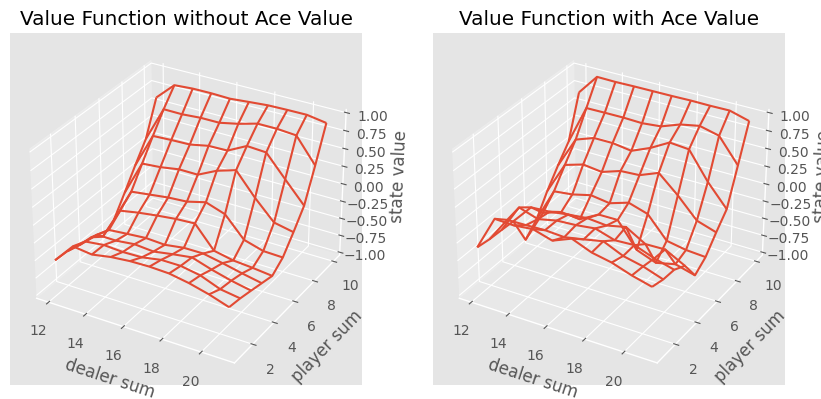

In [368]:
plot_value_table(value_table)

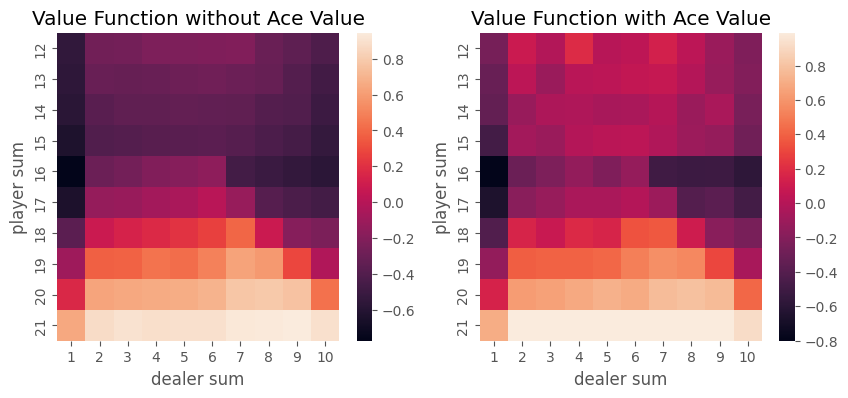

In [351]:
plot_heatmap(value_table)

## MC Control

In [511]:
def first_visit_mc_control(env, epsilon: float = 0.0, n_episodes: int = 10000, random: bool = False):
    q_table = defaultdict(float) if not random else defaultdict(np.random.random)
    
    def policy(obs):
        hit_value = q_table[obs, 1]
        stick_value = q_table[obs, 0]
        if epsilon >= np.random.random():
            return np.random.choice((0, 1))

        return 1 if hit_value > stick_value else 0

    N = defaultdict(int)

    for _ in range(n_episodes):
        observations, actions, rewards = generate_episode(env, policy)
        returns  = 0
        for t in reversed(range(len(observations))):
            R = rewards[t]
            A = actions[t]
            S = observations[t]

            returns += R

            if not (A, S)  in zip(actions[:t], observations[:t]):
                N[S, A] += 1
                q_table[S, A] += (returns - q_table[S, A]) / N[S, A]

    return q_table
        

In [521]:
optimal_q_table = first_visit_mc_control(env, n_episodes=1000000)

In [509]:
def plot_heatmap_q_value(value_table):
    player_sum = np.arange(12, 21+1)
    dealer_sum = np.arange(1, 10 + 1)
    actions = np.array([0, 1])
    usable_ace = np.array([False, True])

    action_value = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace), len(actions)))
    
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_sum):
            for k, ace in enumerate(usable_ace):
                for m , action in enumerate(actions):
                    action_value[i, j, k, m] = value_table[(player, dealer, ace), action]


    fig = plt.figure(figsize=(12, 10))
    for i,  action in enumerate(('Stick', 'Hit')):
        for j, ace in enumerate(('without' , 'with')):
            plt.subplot(221+i*2+j)
            plt.title(f"Action Value Function {ace} Usable Ace for {action}", fontsize=12)
            ax = sns.heatmap(action_value[:, :, j, i], xticklabels=dealer_sum, yticklabels=player_sum)
            plt.ylabel('Player Sum')
            plt.xlabel('Dealer Sum')


    plt.show()

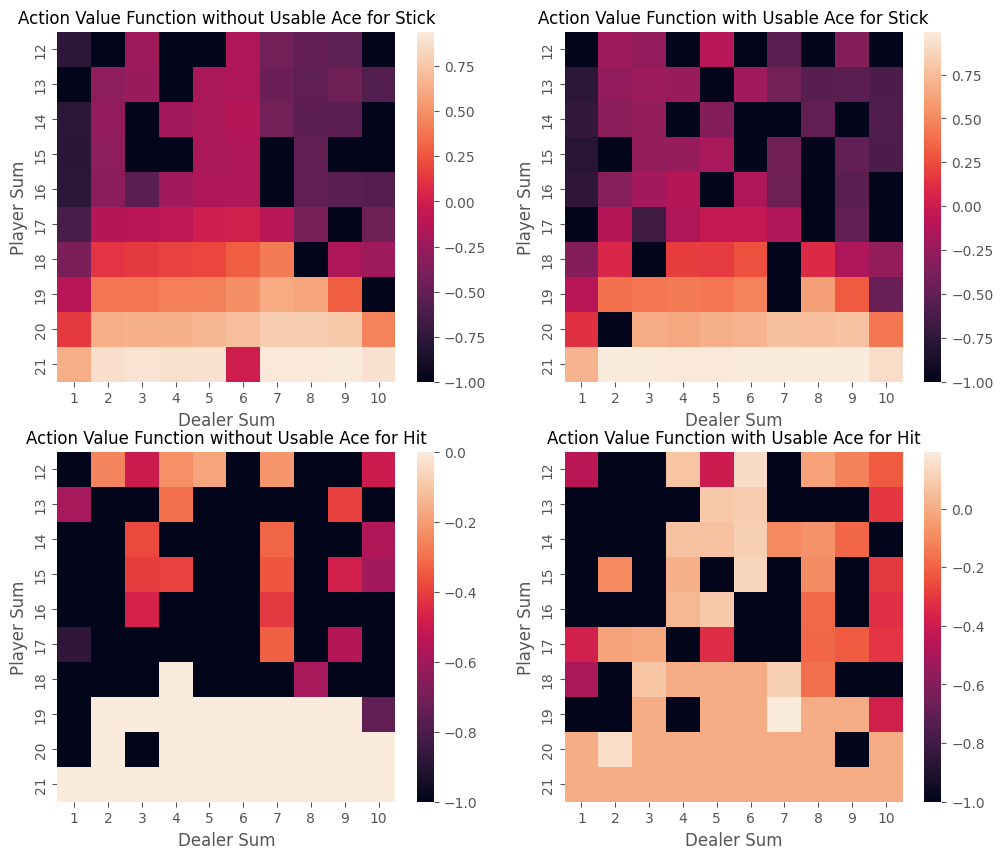

In [522]:
plot_heatmap_q_value(optimal_q_table)

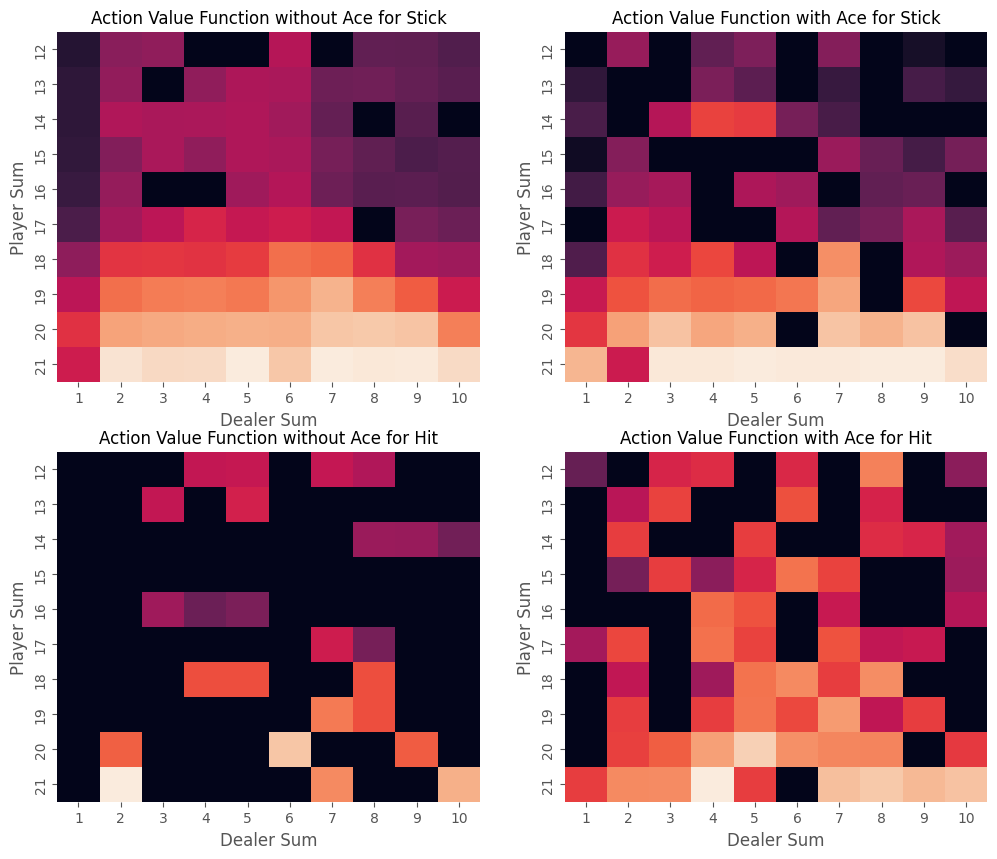

In [496]:
optimal_q_table_with_random_initializaion = first_visit_mc_control(env, 50000, True)
plot_heatmap_q_value(optimal_q_table_with_random_initializaion)

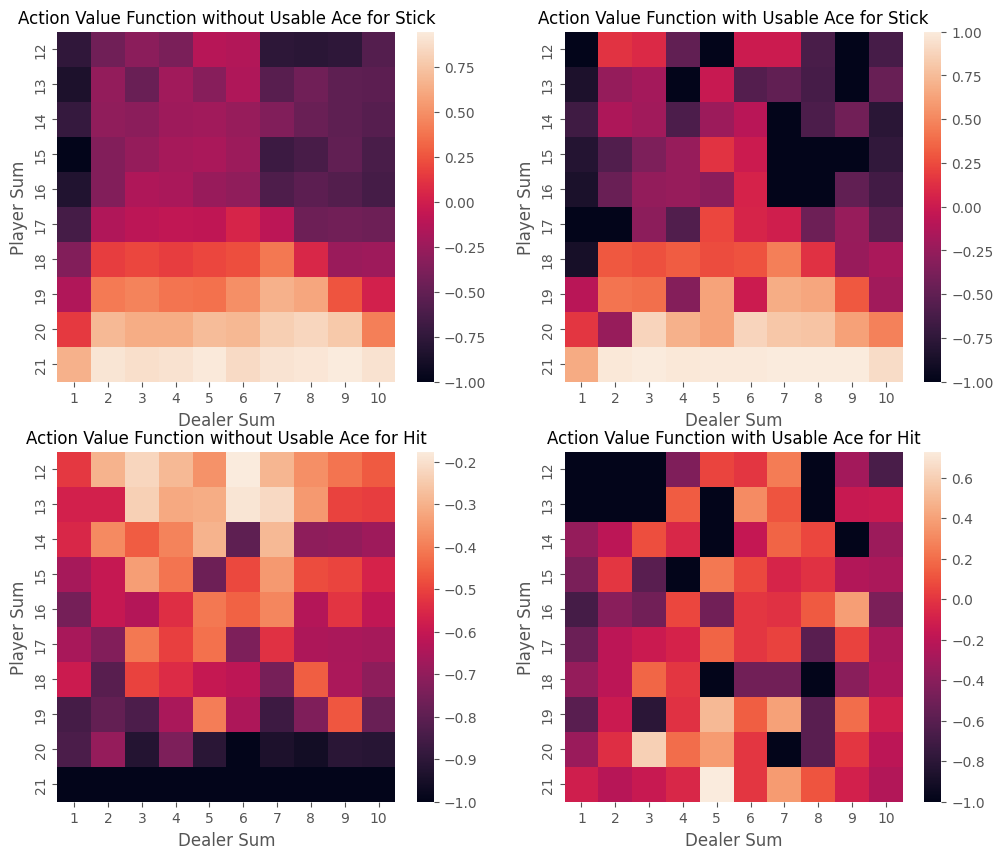

In [532]:
q_table_with_epsilon = first_visit_mc_control(env, 0.1, 50000, True)
plot_heatmap_q_value(q_table_with_epsilon)

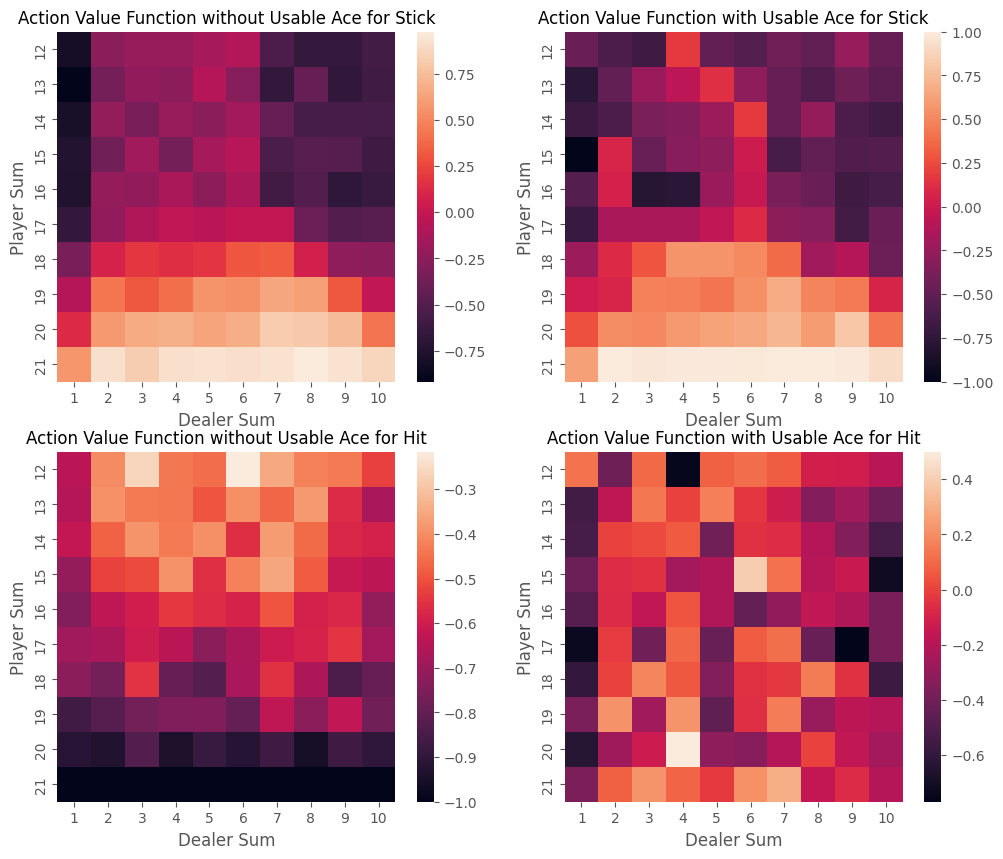

In [533]:
q_table_with_epsilon = first_visit_mc_control(env, 0.5, 50000, True)
plot_heatmap_q_value(q_table_with_epsilon)

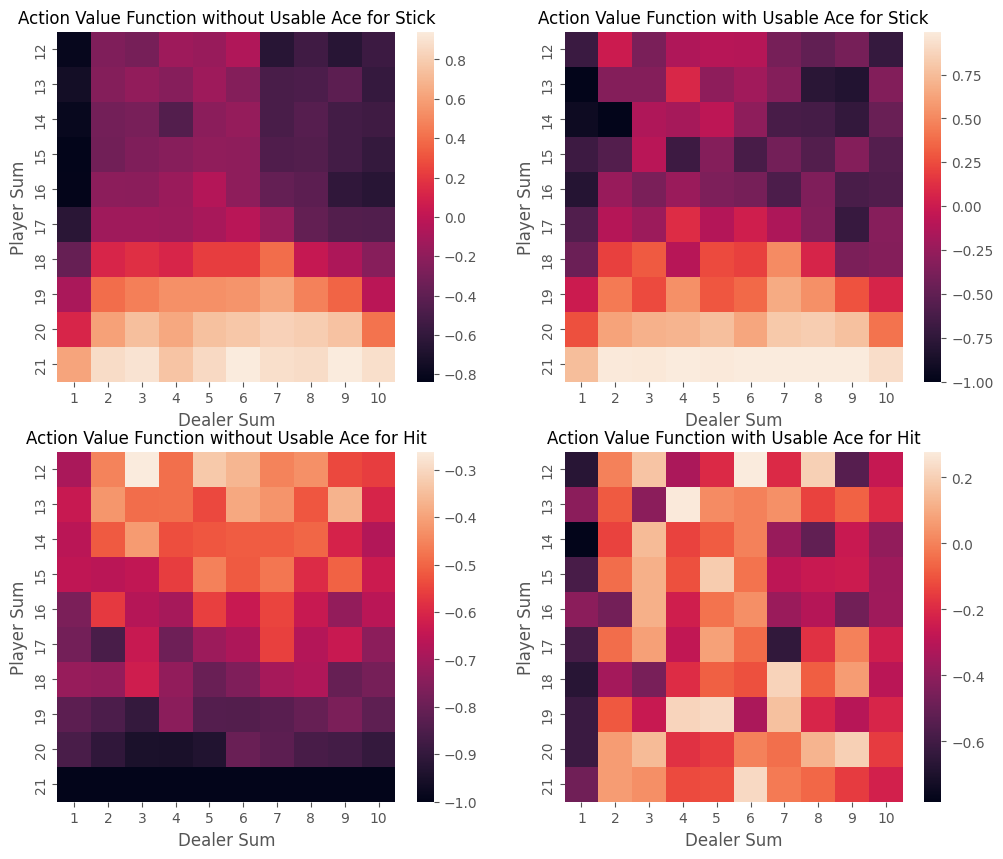

In [529]:
q_table_with_epsilon = first_visit_mc_control(env, 0.6, 50000, True)
plot_heatmap_q_value(q_table_with_epsilon)

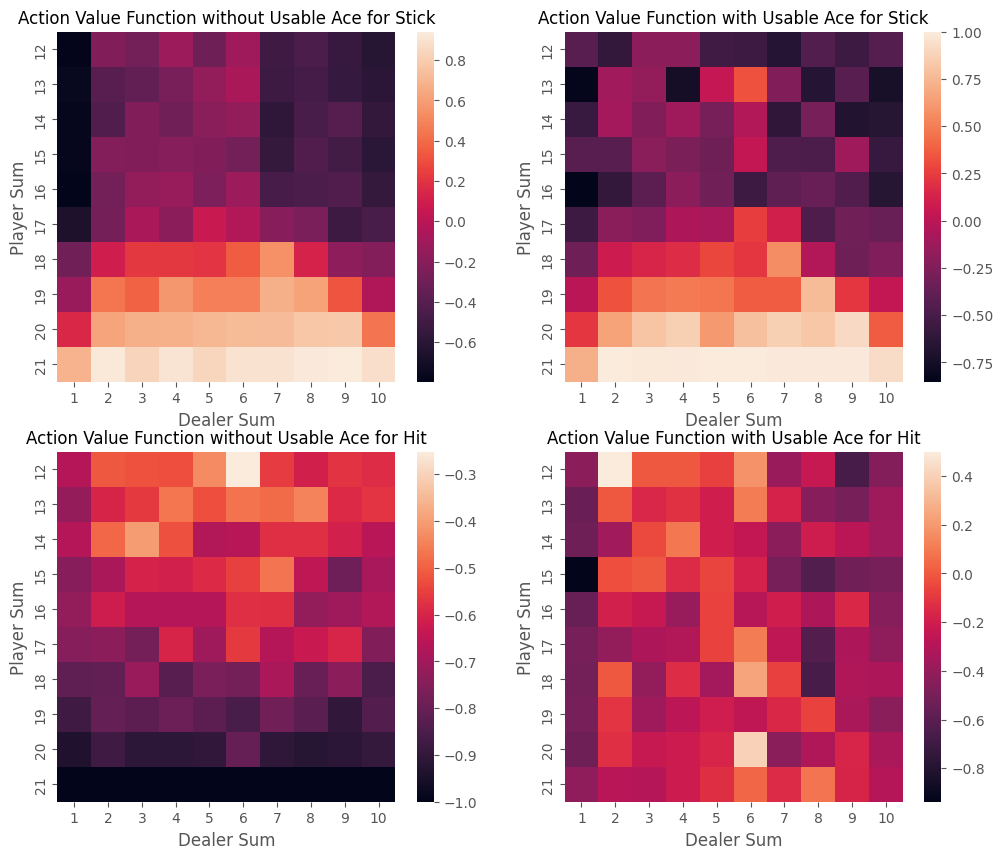

In [530]:
q_table_with_epsilon = first_visit_mc_control(env, 0.8, 50000, True)
plot_heatmap_q_value(q_table_with_epsilon)

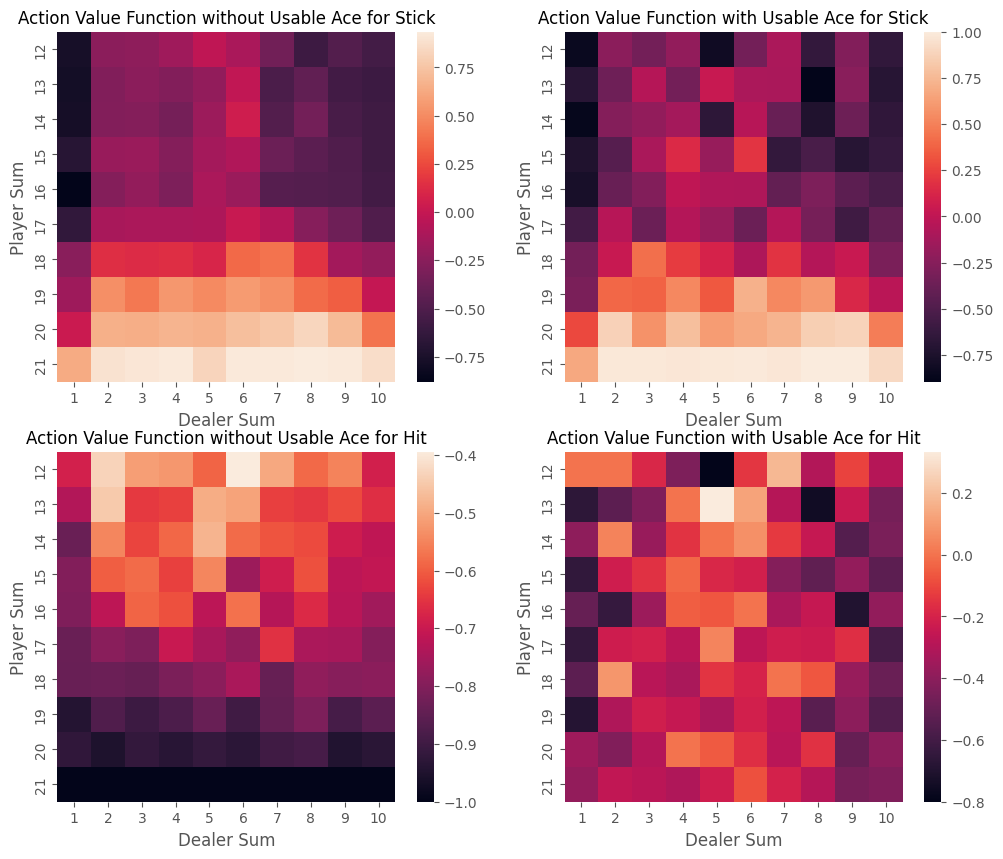

In [531]:
q_table_with_epsilon = first_visit_mc_control(env, 0.95, 50000, True)
plot_heatmap_q_value(q_table_with_epsilon)